In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d

In [24]:
robot_positions = np.zeros((8,8,2))
kdtree_positions = np.zeros((64, 2))
for i in range(8):
    for j in range(8):
        if j%2==0:
            robot_positions[i,j] = (j*37.5, -21.65 + i*-43.301)
            kdtree_positions[i*8 + j, :] = (j*37.5, -21.65 + i*-43.301)
        else:
            robot_positions[i,j] = (j*37.5, i*-43.301)
            kdtree_positions[i*8 + j, :] = (j*37.5, i*-43.301)

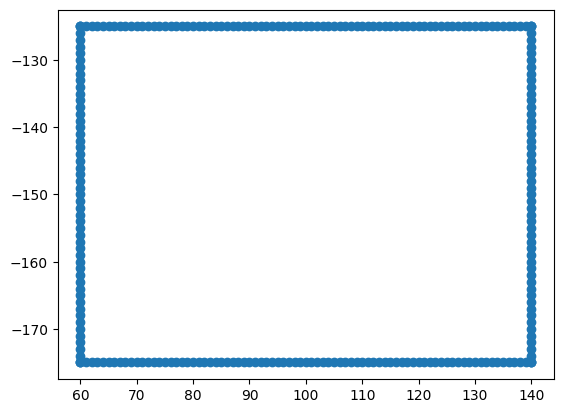

In [20]:
x, y = [100, -150]

def boundary_points(x1, x2, y1, y2):
    corners = np.array([(x1, y1), (x1, y2), (x2, y2), (x2, y1)])
    left_right_edges = np.array([[(x1, y), (x2, y)] for y in range(y1, y2+1)])
    top_bottom_edges = np.array([[(x, y1), (x, y2)] for x in range(x1, x2+1)])    
    boundary_pts = np.concatenate((corners, left_right_edges[:,0], left_right_edges[:,1], top_bottom_edges[:,0],top_bottom_edges[:,1]))
    return boundary_pts

boundary_pts = boundary_points(x-40, x+40, y-25, y+25)
plt.scatter(boundary_pts[:,0],boundary_pts[:,1])

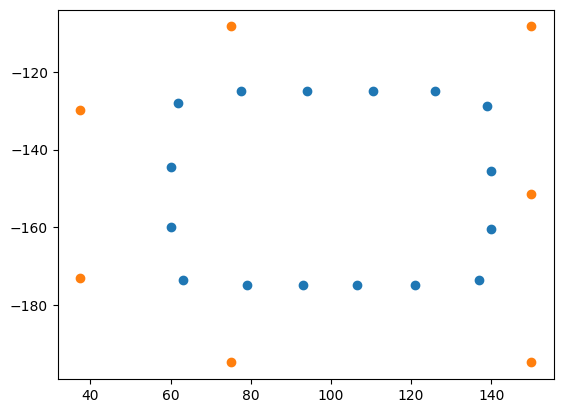

In [40]:
kmeans = KMeans(n_clusters=16, random_state=0).fit(boundary_pts)
cluster_centers = kmeans.cluster_centers_


hull = ConvexHull(cluster_centers)
A, b = hull.equations[:, :-1], hull.equations[:, -1:]
eps = np.finfo(np.float32).eps
idxs = set()
for i in cluster_centers[:,0]:
    for j in cluster_centers[:,1]:
        idx = spatial.KDTree(kdtree_positions).query((i,j))[1]
        if np.all(robot_positions[idx//8][idx%8] @ A.T + b.T < eps, axis=1):
            continue
        else:
            idxs.add((idx//8, idx%8))

idxs = np.array(list(idxs))
neighbors = robot_positions[idxs[:,0], idxs[:,1]]

plt.scatter(*cluster_centers.T)
plt.scatter(*neighbors.T)

In [41]:
idxs

array([[4, 4],
       [2, 4],
       [3, 4],
       [3, 1],
       [4, 2],
       [2, 2],
       [4, 1]])